In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import math
import autograd.numpy as anp
import pymanopt
import pymanopt.manifolds
import pymanopt.solvers
from pymanopt.solvers import TrustRegions
import torch

Tutorial based on https://sebastianraschka.com/Articles/2014_python_lda.html

In [12]:
feature_dict = {i:label for i,label in zip(
                range(4),
                  ('sepal length in cm',
                  'sepal width in cm',
                  'petal length in cm',
                  'petal width in cm', ))}


In [13]:
df = pd.io.parsers.read_csv(
    filepath_or_buffer='https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data',
    header=None,
    sep=',',
    )
df.columns = [l for i,l in sorted(feature_dict.items())] + ['class label']
df.dropna(how="all", inplace=True) # to drop the empty line at file-end

df.tail()


,sepal length in cm,sepal width in cm,petal length in cm,petal width in cm,class label
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


In [14]:
X = df[["sepal length in cm","sepal width in cm","petal length in cm","petal width in cm"]].values
y = df['class label'].values

In [15]:
enc = LabelEncoder()
label_encoder = enc.fit(y)
y = label_encoder.transform(y) + 1

label_dict = {1: 'Setosa', 2: 'Versicolor', 3: 'Virginica'}

In [16]:
%matplotlib inline

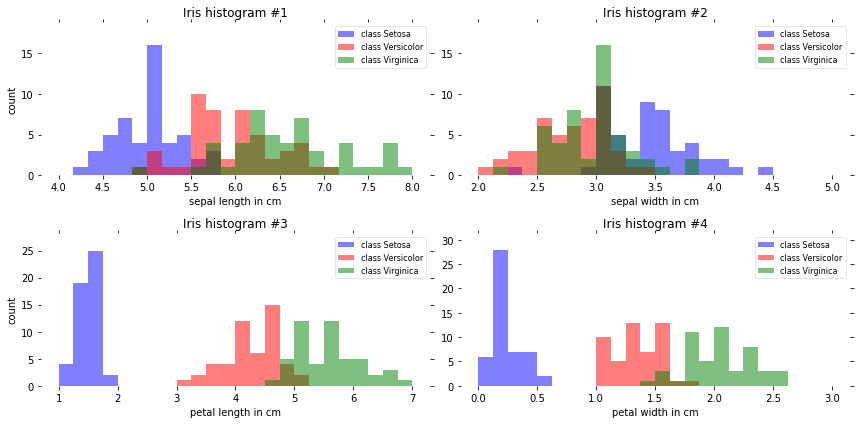

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,6))

for ax,cnt in zip(axes.ravel(), range(4)):  

    # set bin sizes
    min_b = math.floor(np.min(X[:,cnt]))
    max_b = math.ceil(np.max(X[:,cnt]))
    bins = np.linspace(min_b, max_b, 25)

    # plottling the histograms
    for lab,col in zip(range(1,4), ('blue', 'red', 'green')):
        ax.hist(X[y==lab, cnt],
                   color=col,
                   label='class %s' %label_dict[lab],
                   bins=bins,
                   alpha=0.5,)
    ylims = ax.get_ylim()

    # plot annotation
    leg = ax.legend(loc='upper right', fancybox=True, fontsize=8)
    leg.get_frame().set_alpha(0.5)
    ax.set_ylim([0, max(ylims)+2])
    ax.set_xlabel(feature_dict[cnt])
    ax.set_title('Iris histogram #%s' %str(cnt+1))

    # hide axis ticks
    ax.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)    

axes[0][0].set_ylabel('count')
axes[1][0].set_ylabel('count')

fig.tight_layout()       

plt.show()

## Step 1 Compute the d-dimensional mean vector

In [18]:
np.set_printoptions(precision=4)

mean_vectors = []
for cl in range(1,4):
    mean_vectors.append(np.mean(X[y==cl], axis=0))
    print('Mean Vector class %s: %s\n' %(cl, mean_vectors[cl-1]))


Mean Vector class 1: [5.006 3.418 1.464 0.244]

Mean Vector class 2: [5.936 2.77  4.26  1.326]

Mean Vector class 3: [6.588 2.974 5.552 2.026]



## Step 2 Compute the scatter matrices

In [19]:
S_W = np.zeros((4,4))
for cl,mv in zip(range(1,4), mean_vectors):
    class_sc_mat = np.zeros((4,4))                  # scatter matrix for every class
    for row in X[y == cl]:
        row, mv = row.reshape(4,1), mv.reshape(4,1) # make column vectors
        class_sc_mat += (row-mv).dot((row-mv).T)
    S_W += class_sc_mat                             # sum class scatter matrices
print('within-class Scatter Matrix:\n', S_W)


within-class Scatter Matrix:
 [[38.9562 13.683  24.614   5.6556]
 [13.683  17.035   8.12    4.9132]
 [24.614   8.12   27.22    6.2536]
 [ 5.6556  4.9132  6.2536  6.1756]]


In [20]:
overall_mean = np.mean(X, axis=0)

S_B = np.zeros((4,4))
for i,mean_vec in enumerate(mean_vectors):  
    n = X[y==i+1,:].shape[0]
    mean_vec = mean_vec.reshape(4,1) # make column vector
    overall_mean = overall_mean.reshape(4,1) # make column vector
    S_B += n * (mean_vec - overall_mean).dot((mean_vec - overall_mean).T)

print('between-class Scatter Matrix:\n', S_B)


between-class Scatter Matrix:
 [[ 63.2121 -19.534  165.1647  71.3631]
 [-19.534   10.9776 -56.0552 -22.4924]
 [165.1647 -56.0552 436.6437 186.9081]
 [ 71.3631 -22.4924 186.9081  80.6041]]


In [21]:
eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

for i in range(len(eig_vals)):
    eigvec_sc = eig_vecs[:,i].reshape(4,1)   
    print('\nEigenvector {}: \n{}'.format(i+1, eigvec_sc.real))
    print('Eigenvalue {:}: {:.2e}'.format(i+1, eig_vals[i].real))



Eigenvector 1: 
[[ 0.2049]
 [ 0.3871]
 [-0.5465]
 [-0.7138]]
Eigenvalue 1: 3.23e+01

Eigenvector 2: 
[[-0.009 ]
 [-0.589 ]
 [ 0.2543]
 [-0.767 ]]
Eigenvalue 2: 2.78e-01

Eigenvector 3: 
[[ 0.1056]
 [ 0.2524]
 [ 0.3146]
 [-0.7526]]
Eigenvalue 3: 1.10e-15

Eigenvector 4: 
[[ 0.1056]
 [ 0.2524]
 [ 0.3146]
 [-0.7526]]
Eigenvalue 4: 1.10e-15


In [22]:
for i in range(len(eig_vals)):
    eigv = eig_vecs[:,i].reshape(4,1)
    np.testing.assert_array_almost_equal(np.linalg.inv(S_W).dot(S_B).dot(eigv),
                                         eig_vals[i] * eigv,
                                         decimal=6, err_msg='', verbose=True)
print('ok')


ok


In [23]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues

print('Eigenvalues in decreasing order:\n')
for i in eig_pairs:
    print(i[0])


Eigenvalues in decreasing order:

32.27195779972978
0.27756686384005025
5.093285443027438e-15
5.093285443027438e-15


In [24]:
print('Variance explained:\n')
eigv_sum = sum(eig_vals)
for i,j in enumerate(eig_pairs):
    print('eigenvalue {0:}: {1:.2%}'.format(i+1, (j[0]/eigv_sum).real))


Variance explained:

eigenvalue 1: 99.15%
eigenvalue 2: 0.85%
eigenvalue 3: 0.00%
eigenvalue 4: 0.00%


In [25]:
W = np.hstack((eig_pairs[0][1].reshape(4,1), eig_pairs[1][1].reshape(4,1)))
print('Matrix W:\n', W.real)

Matrix W:
 [[ 0.2049 -0.009 ]
 [ 0.3871 -0.589 ]
 [-0.5465  0.2543]
 [-0.7138 -0.767 ]]


In [26]:
X_lda = X.dot(W)
assert X_lda.shape == (150,2), "The matrix is not 150x2 dimensional."

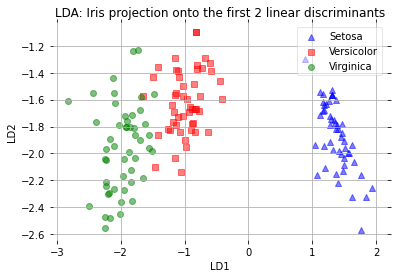

In [27]:
def plot_step_lda():

    ax = plt.subplot(111)
    for label,marker,color in zip(
        range(1,4),('^', 's', 'o'),('blue', 'red', 'green')):

        plt.scatter(x=X_lda[:,0].real[y == label],
                y=X_lda[:,1].real[y == label],
                marker=marker,
                color=color,
                alpha=0.5,
                label=label_dict[label]
                )

    plt.xlabel('LD1')
    plt.ylabel('LD2')

    leg = plt.legend(loc='upper right', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.title('LDA: Iris projection onto the first 2 linear discriminants')

    # hide axis ticks
    plt.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)    

    plt.grid()
    plt.tight_layout
    plt.show()

plot_step_lda()

In [28]:
E = [[-6,4],[-10,-11]]
W = np.matmul(W,E)

Now check when W is gotten from R

In [29]:
X_lda = X.dot(W)
assert X_lda.shape == (150,2), "The matrix is not 150x2 dimensional."

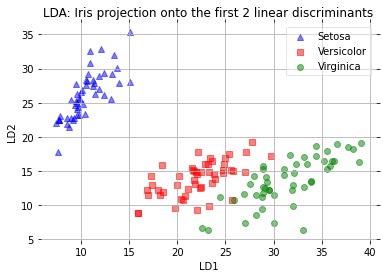

In [30]:
def plot_step_lda():

    ax = plt.subplot(111)
    for label,marker,color in zip(
        range(1,4),('^', 's', 'o'),('blue', 'red', 'green')):

        plt.scatter(x=X_lda[:,0].real[y == label],
                y=X_lda[:,1].real[y == label],
                marker=marker,
                color=color,
                alpha=0.5,
                label=label_dict[label]
                )

    plt.xlabel('LD1')
    plt.ylabel('LD2')

    leg = plt.legend(loc='upper right', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.title('LDA: Iris projection onto the first 2 linear discriminants')

    # hide axis ticks
    plt.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)    

    plt.grid()
    plt.tight_layout
    plt.show()

plot_step_lda()

## Check with R package Grassmann Optm

In [31]:
W = [[0.7519,0.3053],
[-0.2704, 0.4461],
[0.2585, -0.8196],
[-0.5429, -0.1897]]

In [32]:
X_lda = X.dot(W)
assert X_lda.shape == (150,2), "The matrix is not 150x2 dimensional."

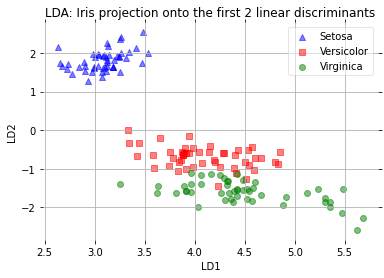

In [33]:
def plot_step_lda():

    ax = plt.subplot(111)
    for label,marker,color in zip(
        range(1,4),('^', 's', 'o'),('blue', 'red', 'green')):

        plt.scatter(x=X_lda[:,0].real[y == label],
                y=X_lda[:,1].real[y == label],
                marker=marker,
                color=color,
                alpha=0.5,
                label=label_dict[label]
                )

    plt.xlabel('LD1')
    plt.ylabel('LD2')

    leg = plt.legend(loc='upper right', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.title('LDA: Iris projection onto the first 2 linear discriminants')

    # hide axis ticks
    plt.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)    

    plt.grid()
    plt.tight_layout
    plt.show()

plot_step_lda()

## Try python package manoptim

Try the example

In [34]:
anp.random.seed(42)

dim = 3
manifold = pymanopt.manifolds.Sphere(dim)

matrix = anp.random.normal(size=(dim, dim))
matrix = 0.5 * (matrix + matrix.T)

@pymanopt.function.Autograd
def cost(point):
    return -point @ matrix @ point

problem = pymanopt.Problem(manifold=manifold, cost=cost)

solver = pymanopt.solvers.SteepestDescent()
solution = solver.solve(problem)

eigenvalues, eigenvectors = anp.linalg.eig(matrix)
dominant_eigenvector = eigenvectors[:, eigenvalues.argmax()]

print("Dominant eigenvector:", dominant_eigenvector)
print("Pymanopt solution:", solution)

 iter		   cost val	    grad. norm
    1	+1.1041943339110254e+00	5.65626470e-01
    2	+5.2849633289004561e-01	8.90742722e-01
    3	-8.0741058657312559e-01	2.23937710e+00
    4	-1.2667369971251594e+00	1.59671326e+00
    5	-1.4100298597091836e+00	1.11228845e+00
    6	-1.5219408277812503e+00	2.45507203e-01
    7	-1.5269956262562046e+00	6.81712914e-02
    8	-1.5273114803528711e+00	3.40941735e-02
    9	-1.5273905588875485e+00	1.70222768e-02
   10	-1.5274100956128573e+00	8.61140952e-03
   11	-1.5274154319869830e+00	3.90706914e-03
   12	-1.5274156215853552e+00	3.62943720e-03
   13	-1.5274162595152965e+00	2.47643447e-03
   14	-1.5274168030609059e+00	3.66398563e-04
   15	-1.5274168133149573e+00	1.45209698e-04
   16	-1.5274168150025647e+00	4.96155220e-05
   17	-1.5274168150483862e+00	4.42268896e-05
   18	-1.5274168151842891e+00	2.13593811e-05
   19	-1.5274168152084981e+00	1.37493542e-05
   20	-1.5274168152227032e+00	5.68191958e-06
   21	-1.5274168152254950e+00	1.21561610e-06
   22	-1.527416815225

## Solve my problem


In [36]:
np.linalg.inv(S_W)

array([[ 0.074 , -0.0371, -0.0613,  0.0238],
       [-0.0371,  0.0976,  0.0188, -0.0628],
       [-0.0613,  0.0188,  0.1005, -0.0606],
       [ 0.0238, -0.0628, -0.0606,  0.2514]])

In [37]:
def create_cost_egrad_ehess(manifold, matrix_B, matrix_W, backend):
    egrad = ehess = None

    if backend == "Autograd":

        @pymanopt.function.Autograd
        def cost(X):
            return -np.trace(X.T @ matrix_B @ X)
    elif backend == "PyTorch":

        matrix_B = torch.from_numpy(matrix_B)
        matrix_W = torch.from_numpy(matrix_W)
        @pymanopt.function.PyTorch
        def cost(X):
            return -torch.trace( torch.matmul( torch.matmul(X.T, torch.matmul(matrix_B, X)), torch.inverse(torch.matmul( X.T, torch.matmul(matrix_W,X) ))))
    else:
        raise ValueError(f"Unsupported backend '{backend}'")

    return cost, egrad, ehess

In [38]:
dim = 4
subspace_dimension = 2
manifold = pymanopt.manifolds.Grassmann(n=dim,p=subspace_dimension)
#matrix = anp.random.normal(size=(dim, dim))
#matrix = 0.5 * (matrix + matrix.T)

cost, egrad, ehess = create_cost_egrad_ehess(manifold, S_B, S_W, "PyTorch")
problem = pymanopt.Problem(manifold, cost=cost, egrad=egrad, ehess=ehess)
solver = TrustRegions()
estimated_spanning_set = solver.solve(
problem, Delta_bar=8 * np.sqrt(subspace_dimension)
)


Optimizing...
                                            f: -4.864199e+00   |grad|: 1.939665e+01
acc TR-   k:     1     num_inner:     0     f: -2.679638e+01   |grad|: 1.633870e+01   negative curvature
acc TR+   k:     2     num_inner:     0     f: -3.100130e+01   |grad|: 8.741808e+00   exceeded trust region
REJ TR-   k:     3     num_inner:     2     f: -3.100130e+01   |grad|: 8.741808e+00   negative curvature
acc TR+   k:     4     num_inner:     0     f: -3.212951e+01   |grad|: 4.043241e+00   exceeded trust region
acc TR-   k:     5     num_inner:     2     f: -3.222442e+01   |grad|: 5.907200e+00   negative curvature
acc TR+   k:     6     num_inner:     2     f: -3.240751e+01   |grad|: 3.554671e-01   negative curvature
acc TR+   k:     7     num_inner:     2     f: -3.243341e+01   |grad|: 2.423526e+00   negative curvature
acc       k:     8     num_inner:     2     f: -3.249627e+01   |grad|: 4.254427e+00   negative curvature
acc       k:     9     num_inner:     1     f: -3.253101

In [39]:
estimated_spanning_set

array([[-0.1893, -0.0911],
       [-0.2273, -0.7387],
       [ 0.4524,  0.4711],
       [ 0.8413, -0.4734]])

In [40]:
estimated_spanning_set

array([[-0.1893, -0.0911],
       [-0.2273, -0.7387],
       [ 0.4524,  0.4711],
       [ 0.8413, -0.4734]])

In [41]:
eigenvalues, eigenvectors = np.linalg.eig(S_B)
column_indices = np.argsort(eigenvalues)[-subspace_dimension:]
spanning_set = eigenvectors[:, column_indices]

In [42]:
spanning_set

array([[-0.3326,  0.3269],
       [-0.8878, -0.1096],
       [ 0.1364,  0.8628],
       [-0.2874,  0.3698]])

In [43]:
W = estimated_spanning_set
X_lda = X.dot(W)
assert X_lda.shape == (150,2), "The matrix is not 150x2 dimensional."

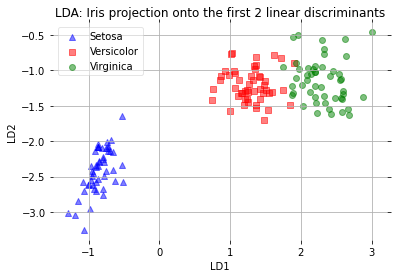

In [44]:
def plot_step_lda():

    ax = plt.subplot(111)
    for label,marker,color in zip(
        range(1,4),('^', 's', 'o'),('blue', 'red', 'green')):

        plt.scatter(x=X_lda[:,0].real[y == label],
                y=X_lda[:,1].real[y == label],
                marker=marker,
                color=color,
                alpha=0.5,
                label=label_dict[label]
                )

    plt.xlabel('LD1')
    plt.ylabel('LD2')

    leg = plt.legend(loc='upper left', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.title('LDA: Iris projection onto the first 2 linear discriminants')

    # hide axis ticks
    plt.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)    

    plt.grid()
    plt.tight_layout
    plt.show()

plot_step_lda()

In [ ]:
X

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
       [4.9, 3